## 1 - Lien vers le drive ##

In [1]:
from google.colab import drive

# autorisation avec un code
drive.mount('/content/drive')

Mounted at /content/drive


## 2 - Import des librairies ##


In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from random import seed
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 3 - Chargement de données ##


In [3]:
file_path = "/content/drive/My Drive/Supervised_proj/VisaPremierAfterPrep.csv"
visa_data = pd.read_csv(file_path, index_col=0)
quali_names = ["departem", "ptvente", "sitfamil", "csp", "sexer", "codeqlt"]
visa_data = visa_data.drop(columns=quali_names)
array = visa_data.to_numpy()
X = array[:,:-1]
Y = array[:,-1]

# 4 - Oversampling

In [4]:
%%capture
!pip install imblearn

In [5]:
# Tune SVM
# Standardiser les données
scaler = StandardScaler()

# Utilisation d'une technique d'oversampling
smote = SMOTE()

num_folds = 10
seed = 2021
X_train, Y_train = smote.fit_resample(X, Y)
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.860691 using {'C': 2.0, 'kernel': 'rbf'}


In [6]:
# Tune KNN
neighbors = list(range(1, 20))
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.874086 using {'n_neighbors': 1}


In [7]:
# Tune RandomForestClassifier
n_estimators = [10, 20, 30, 40, 50, 100, 200]
param_grid = dict(n_estimators=n_estimators)
model = RandomForestClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.894391 using {'n_estimators': 100}


In [ ]:
# Nous avons choisi 10 modèles
models = {
    'KNN': KNeighborsClassifier(n_neighbors=1),
    'GBM': GradientBoostingClassifier(),
    'LR': LogisticRegression(),
    'RF': RandomForestClassifier(n_estimators=100),
    'ET': ExtraTreesClassifier(n_estimators=100),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'CART': DecisionTreeClassifier(),
    'SVM': SVC(probability = True, C=2.0, kernel='rbf'),
    'AB': AdaBoostClassifier(n_estimators=20)
    }

seed = 2021
results, names, result_str = list(), list(), list()
best_predictions = {}

for name, model in models.items():
    print(name)
    best_result = 0
    best_cv_results = list()
    y_probas_pred = list()
    iter_max = 50
    i = 1
    while i <= iter_max:
        X_train, Y_train = smote.fit_resample(X, Y)
        X_train = scaler.fit_transform(X_train)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        if cv_results.mean() > best_result:
            best_result = cv_results.mean()
            y_probas_pred = cross_val_predict(model, X_train, Y_train, cv=kfold, method="predict_proba")
            best_cv_results = cv_results 
        i+=1
    results.append(best_cv_results)
    names.append(name)
    to_add = f" model {name}, best CV = {best_cv_results.mean()} +- {best_cv_results.std()}"
    result_str.append(to_add)
    best_predictions[name] = y_probas_pred
# Show results
for string in result_str:
    print(string)

KNN
GBM
LR
RF
ET
LDA
QDA
CART
SVM
AB
 model KNN, best CV = 0.8775879050526937 +- 0.05720295781045926
 model GBM, best CV = 0.9188466463114352 +- 0.07312991846681721
 model LR, best CV = 0.8516103614695163 +- 0.05770350341264755
 model RF, best CV = 0.8999852260415642 +- 0.09073588665611644
 model ET, best CV = 0.9223726977248103 +- 0.05310809182365121
 model LDA, best CV = 0.8242342164877376 +- 0.06622012902231303
 model QDA, best CV = 0.8198463508322664 +- 0.10949722902258718
 model CART, best CV = 0.8593469910371319 +- 0.10282520927203957
 model SVM, best CV = 0.8705111789618831 +- 0.040312380116271064
 model AB, best CV = 0.9132374667585935 +- 0.05591730122535007


In [ ]:
for model in best_predictions.keys():
    print(model, ": ", roc_auc_score(Y_train, best_predictions[model][:,1]))

KNN :  0.8774509803921569
GBM :  0.9608049101993738
LR :  0.9123178683238
RF :  0.9620612951062779
ET :  0.9715533272132382
LDA :  0.8906464546602956
QDA :  0.9193844204348406
CART :  0.857843137254902
SVM :  0.9230084190538962
AB :  0.9657049094147463


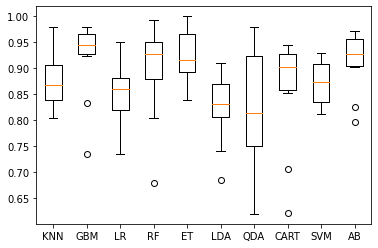

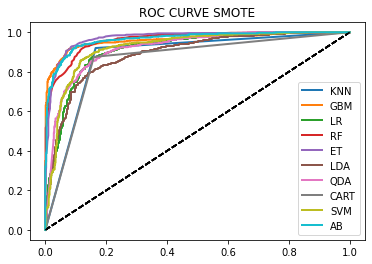

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig("boxplot_SMOTE.png", format="png", dpi=1200)
plt.show()
for model in best_predictions.keys():
  fpr, tpr, thresh = roc_curve(Y_train, best_predictions[model][:,1])
  plt.plot(fpr, tpr, linewidth=2, label=model)
  plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.title('ROC CURVE SMOTE')
plt.savefig("roc_SMOTE.png", format="png", dpi=1200)

## 5 - Undersampling ##


In [ ]:
from random import seed
# Standardiser les données
scaler = StandardScaler()

# Utilisation de RandomUnderSampler
under_sampling = RandomUnderSampler()

# Nous avons choisi 10 modèles
models = {
    'KNN': KNeighborsClassifier(n_neighbors=1),
    'GBM': GradientBoostingClassifier(),
    'LR': LogisticRegression(),
    'RF': RandomForestClassifier(n_estimators=100),
    'ET': ExtraTreesClassifier(n_estimators=100),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'CART': DecisionTreeClassifier(),
    'SVM': SVC(probability = True, C=2.0, kernel='rbf'),
    'AB': AdaBoostClassifier(n_estimators=20)
    }

results, names, result_str = list(), list(), list()
best_predictions = {}

for name, model in models.items():
    print(name)
    best_result = 0
    best_cv_results = list()
    y_probas_pred = list()
    iter_max = 50
    i = 1
    while i <= iter_max:
        X_train, Y_train = under_sampling.fit_resample(X, Y)
        X_train = scaler.fit_transform(X_train)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        if cv_results.mean() > best_result:
            best_result = cv_results.mean()
            y_probas_pred = cross_val_predict(model,X_train, Y_train, cv=kfold, method="predict_proba")
            best_cv_results = cv_results 
        i+=1
    results.append(best_cv_results)
    names.append(name)
    to_add = f" model {name}, best CV = {best_cv_results.mean()} +- {best_cv_results.std()}"
    result_str.append(to_add)
    best_predictions[name] = y_probas_pred

# Show results
for string in result_str:
    print(string)

KNN
GBM
LR
RF
ET
LDA
QDA
CART
SVM
AB
 model KNN, best CV = 0.8535406885758998 +- 0.07076463648242373
 model GBM, best CV = 0.9024843505477309 +- 0.14522877336324083
 model LR, best CV = 0.9037949921752737 +- 0.05832248214211458
 model RF, best CV = 0.8997652582159624 +- 0.16859032978749508
 model ET, best CV = 0.9247848200312989 +- 0.07411972863544056
 model LDA, best CV = 0.8689358372456963 +- 0.06262598397622453
 model QDA, best CV = 0.8452660406885759 +- 0.13887210879700634
 model CART, best CV = 0.8344092331768389 +- 0.14334647480439613
 model SVM, best CV = 0.917781690140845 +- 0.03497300823776252
 model AB, best CV = 0.9150821596244132 +- 0.12783126060299238


In [ ]:
for model in best_predictions.keys():
    print(model, ": ", roc_auc_score(Y_train, best_predictions[model][:,1]))

KNN :  0.8537604456824514
GBM :  0.9595052800645557
LR :  0.9688860266447343
RF :  0.943137467896742
ET :  0.970294302496101
LDA :  0.9369418300602882
QDA :  0.918009636796735
CART :  0.82033426183844
SVM :  0.9641141828508467
AB :  0.9767692677741482


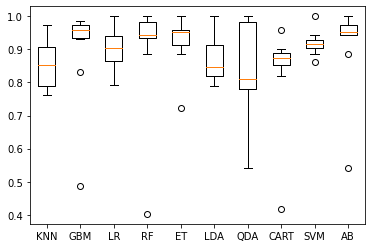

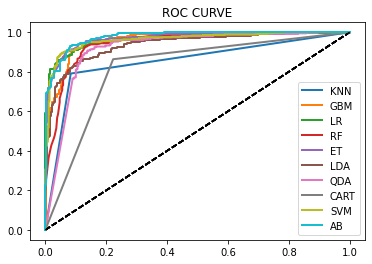

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig("boxplot.png", format="png", dpi=1200)
plt.show()
for model in best_predictions.keys():
  fpr, tpr, thresh = roc_curve(Y_train, best_predictions[model][:,1])
  plt.plot(fpr, tpr, linewidth=2, label=model)
  plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.title('ROC CURVE')
plt.savefig("roc.png", format="png", dpi=1200)